# ASL Recognition Training - MediaPipe

**MediaPipe Hand Landmarks** (hanya untuk keypoint extraction).

## Pipeline:
1. Load dataset
2. **Extract keypoints dengan MediaPipe** (21 hand landmarks)
3. Apply data augmentation
4. Train SVM classifier
5. Evaluate & save model

In [1]:
!pip install tqdm
!pip install mediapipe


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys
import os

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from tqdm import tqdm

from src.config import *
from src.utils import MediaPipeHandExtractor, augment_image, plot_confusion_matrix, print_classification_report

print("Imports successful!")
print(f"MediaPipe confidence: {MEDIAPIPE_CONFIDENCE}")
print(f"Augmentation: {'Enabled' if AUGMENTATION_ENABLED else 'Disabled'}")

Imports successful!
MediaPipe confidence: 0.3
Augmentation: Enabled


## 1. Load Dataset & Extract MediaPipe Keypoints

In [3]:
print("="*60)
print("LOADING DATASET & EXTRACTING KEYPOINTS")
print("="*60)
print(f"Dataset: {DATASET_PATH}")
print(f"Augmentation factor: {AUGMENTATION_FACTOR}x\n")

# Initialize MediaPipe (only for keypoint extraction)
extractor = MediaPipeHandExtractor(confidence=MEDIAPIPE_CONFIDENCE)

X = []
y = []
failed = 0

for class_idx, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(class_path):
        print(f"⚠️  Class {class_name} not found")
        continue
    
    files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]
    print(f"Class {class_name}: {len(files)} images")
    
    for img_file in tqdm(files, desc=f"  {class_name}"):
        img_path = os.path.join(class_path, img_file)
        image = cv2.imread(img_path)
        
        if image is None:
            failed += 1
            continue
        
        # Extract keypoints with MediaPipe (21 landmarks)
        features = extractor.extract_normalized_landmarks(image)
        
        if features is not None:
            X.append(features)
            y.append(class_idx)
            
            # Data Augmentation
            if AUGMENTATION_ENABLED:
                for _ in range(AUGMENTATION_FACTOR - 1):
                    aug_img = augment_image(
                        image,
                        rotation_range=ROTATION_RANGE,
                        brightness_range=BRIGHTNESS_RANGE,
                        noise_factor=NOISE_FACTOR
                    )
                    aug_features = extractor.extract_normalized_landmarks(aug_img)
                    
                    if aug_features is not None:
                        X.append(aug_features)
                        y.append(class_idx)
        else:
            failed += 1

X = np.array(X)
y = np.array(y)

print(f"\n✅ Dataset loaded!")
print(f"   Total samples: {len(X)}")
print(f"   Feature shape: {X.shape} (21 landmarks × 3 coordinates = 63)")
print(f"   Failed images: {failed}")
print(f"   Classes: {len(CLASSES)}")

LOADING DATASET & EXTRACTING KEYPOINTS
Dataset: d:\SEM 5\CompVis\Another Final Project - ASL\ComputerVision\model\SignAlphaSet\SignAlphaSet
Augmentation factor: 2x

Class A: 1000 images


  A: 100%|██████████| 1000/1000 [00:41<00:00, 24.14it/s]


Class B: 1000 images


  B: 100%|██████████| 1000/1000 [00:41<00:00, 24.29it/s]


Class C: 1000 images


  C: 100%|██████████| 1000/1000 [00:41<00:00, 24.34it/s]


Class D: 1000 images


  D: 100%|██████████| 1000/1000 [00:42<00:00, 23.77it/s]


Class E: 1000 images


  E: 100%|██████████| 1000/1000 [00:42<00:00, 23.72it/s]


Class F: 1000 images


  F: 100%|██████████| 1000/1000 [00:43<00:00, 22.75it/s]


Class G: 1000 images


  G: 100%|██████████| 1000/1000 [00:49<00:00, 20.14it/s]


Class H: 1000 images


  H: 100%|██████████| 1000/1000 [00:48<00:00, 20.52it/s]


Class I: 1000 images


  I: 100%|██████████| 1000/1000 [00:48<00:00, 20.53it/s]


Class J: 1000 images


  J: 100%|██████████| 1000/1000 [00:53<00:00, 18.73it/s]


Class K: 1000 images


  K: 100%|██████████| 1000/1000 [00:53<00:00, 18.74it/s]


Class L: 1000 images


  L: 100%|██████████| 1000/1000 [00:50<00:00, 19.99it/s]


Class M: 1000 images


  M: 100%|██████████| 1000/1000 [00:48<00:00, 20.62it/s]


Class N: 1000 images


  N: 100%|██████████| 1000/1000 [00:48<00:00, 20.58it/s]


Class O: 1000 images


  O: 100%|██████████| 1000/1000 [00:40<00:00, 24.48it/s]


Class P: 1000 images


  P: 100%|██████████| 1000/1000 [00:49<00:00, 20.40it/s]


Class Q: 1000 images


  Q: 100%|██████████| 1000/1000 [00:49<00:00, 20.26it/s]


Class R: 1000 images


  R: 100%|██████████| 1000/1000 [00:49<00:00, 20.21it/s]


Class S: 1000 images


  S: 100%|██████████| 1000/1000 [00:49<00:00, 20.37it/s]


Class T: 1000 images


  T: 100%|██████████| 1000/1000 [00:48<00:00, 20.45it/s]


Class U: 1000 images


  U: 100%|██████████| 1000/1000 [00:49<00:00, 20.32it/s]


Class V: 1000 images


  V: 100%|██████████| 1000/1000 [00:49<00:00, 20.26it/s]


Class W: 1000 images


  W: 100%|██████████| 1000/1000 [00:50<00:00, 19.78it/s]


Class X: 1000 images


  X: 100%|██████████| 1000/1000 [00:51<00:00, 19.29it/s]


Class Y: 1000 images


  Y: 100%|██████████| 1000/1000 [00:49<00:00, 20.26it/s]


Class Z: 1000 images


  Z: 100%|██████████| 1000/1000 [00:48<00:00, 20.65it/s]



✅ Dataset loaded!
   Total samples: 51200
   Feature shape: (51200, 63) (21 landmarks × 3 coordinates = 63)
   Failed images: 295
   Classes: 26


## Visualize MediaPipe Hand Landmarks

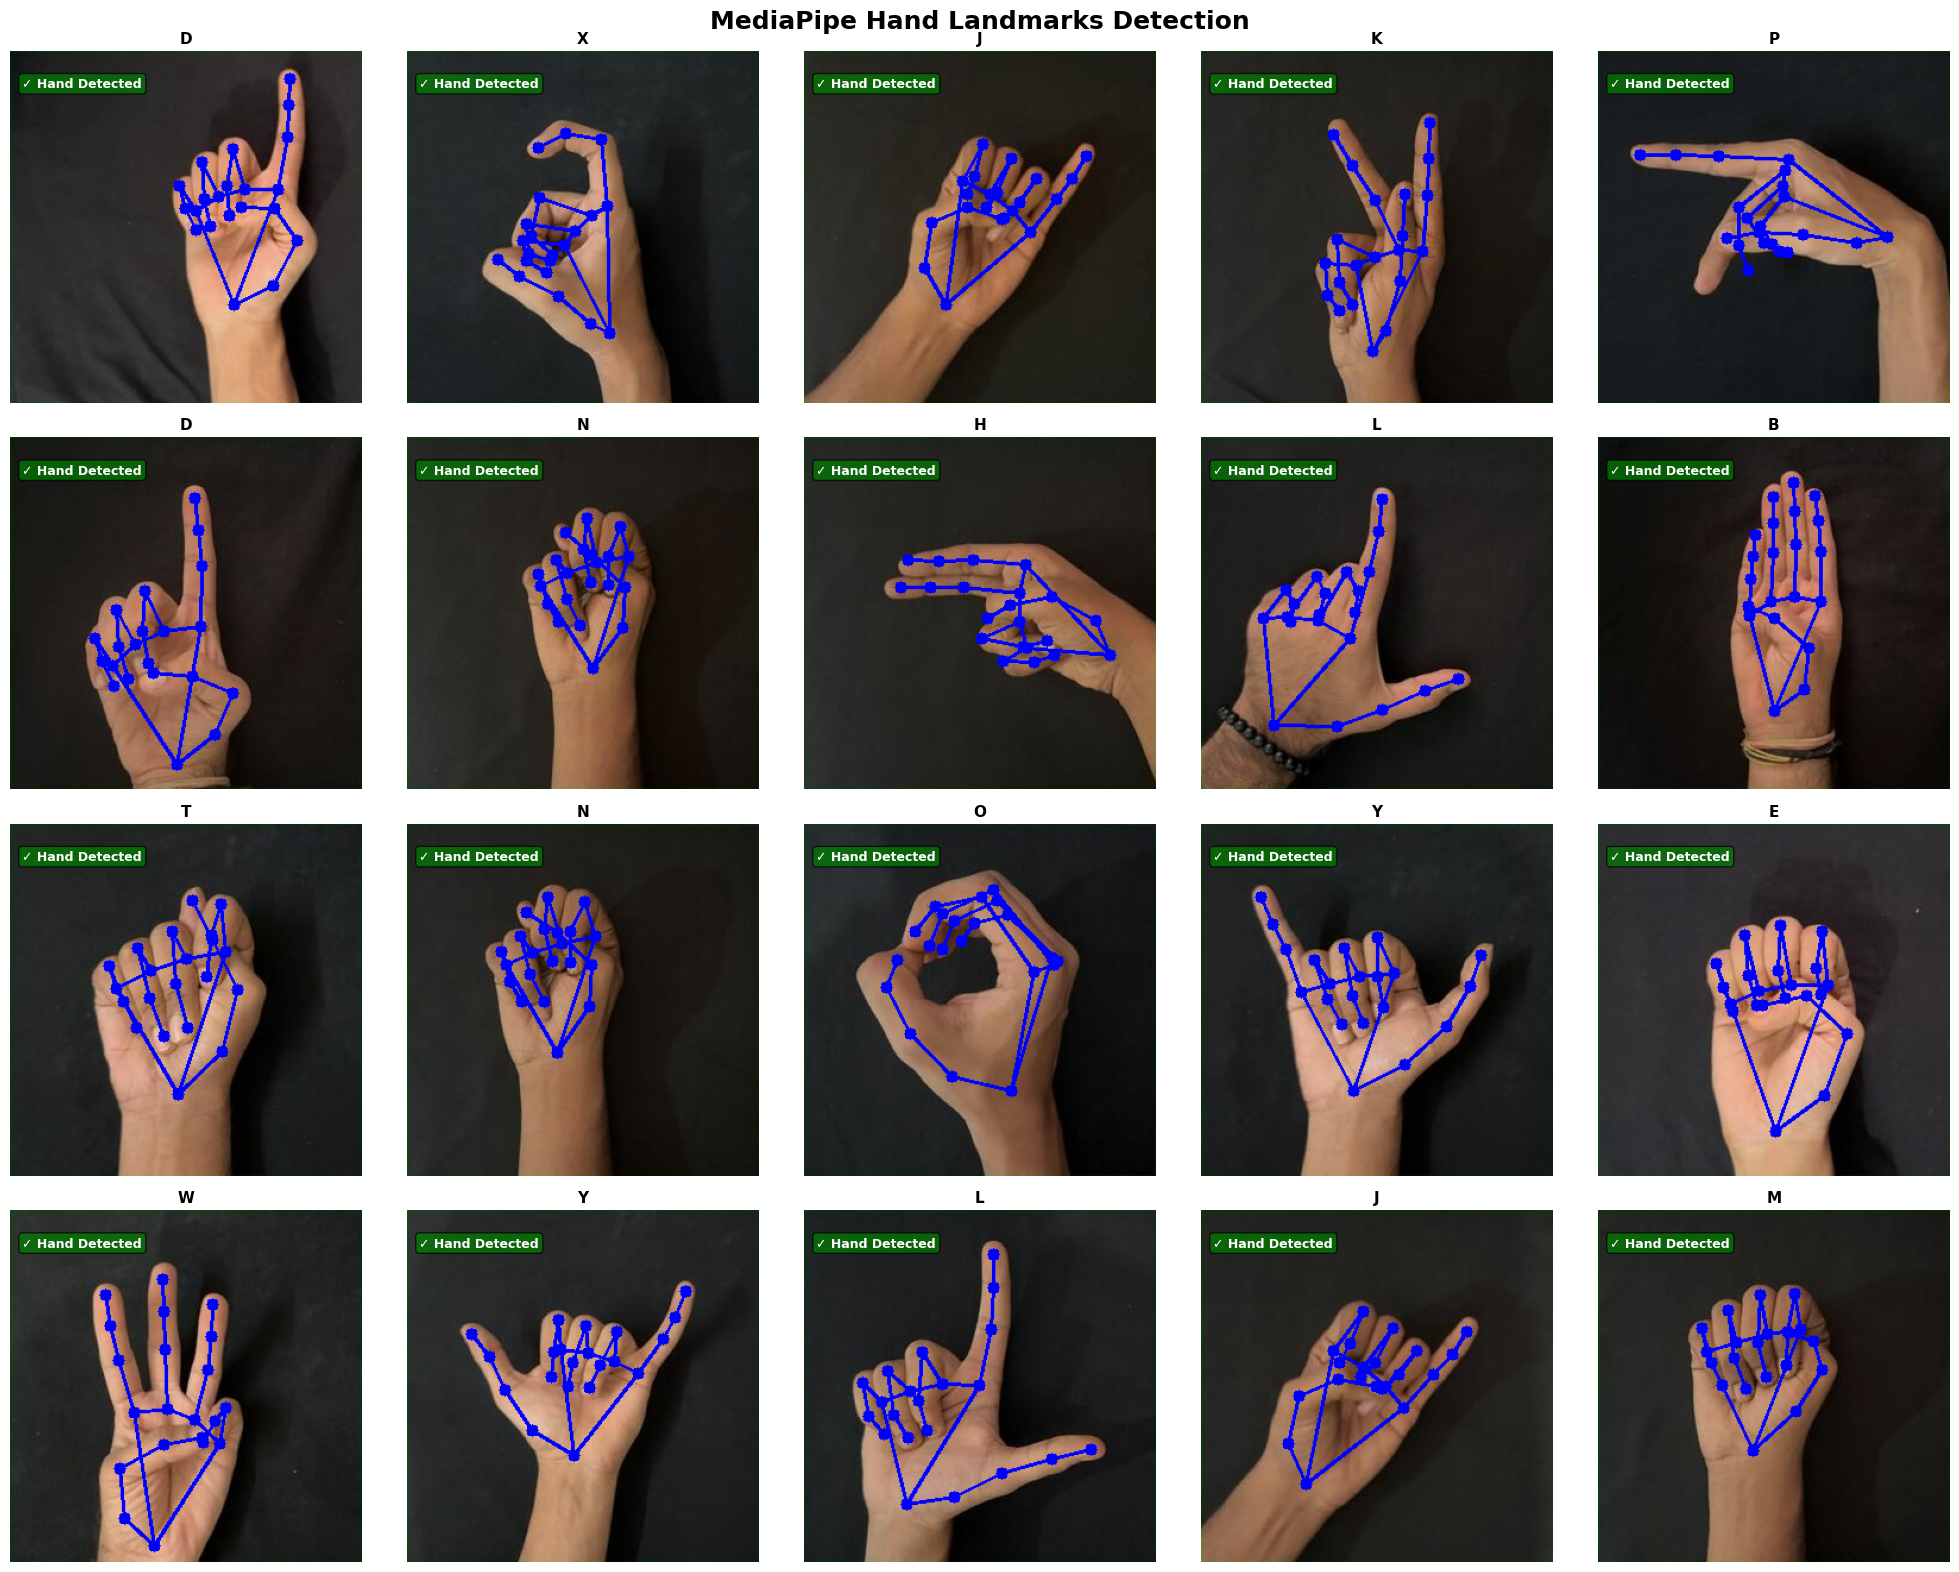


📊 MediaPipe detects 21 hand landmarks:
   - 1 wrist
   - 4 thumb points
   - 4 index points
   - 4 middle points
   - 4 ring points
   - 4 pinky points
   Total: 21 landmarks × 3 coordinates = 63 features


In [12]:
import matplotlib.pyplot as plt
import random
import math

# Number of samples you want
num_samples = 20

# Auto-generate grid size (rows x cols)
cols = 5
rows = math.ceil(num_samples / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
fig.suptitle('MediaPipe Hand Landmarks Detection', fontsize=18, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flat if isinstance(axes, np.ndarray) else [axes]

# Pick random classes (allow repetition if needed)
selected_classes = random.choices(CLASSES, k=num_samples)

for ax, class_name in zip(axes, selected_classes):
    # Pick random image
    class_path = os.path.join(DATASET_PATH, class_name)
    files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]
    random_file = random.choice(files)
    img_path = os.path.join(class_path, random_file)

    # Load + visualize
    image = cv2.imread(img_path)
    annotated_image, success = extractor.visualize_landmarks(image)

    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    ax.imshow(annotated_image_rgb)
    ax.set_title(f'{class_name}', fontsize=11, fontweight='bold')
    ax.axis('off')

    # Label
    status = '✓ Hand Detected' if success else '✗ No Hand'
    color = 'green' if success else 'red'

    ax.text(
        10, 30, status,
        bbox=dict(boxstyle='round', facecolor=color, alpha=0.7),
        fontsize=9, color='white', fontweight='bold'
    )

# Hide unused subplots if any
for ax in list(axes)[num_samples:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n📊 MediaPipe detects 21 hand landmarks:")
print("   - 1 wrist")
print("   - 4 thumb points")
print("   - 4 index points")
print("   - 4 middle points")
print("   - 4 ring points")
print("   - 4 pinky points")
print("   Total: 21 landmarks × 3 coordinates = 63 features")

## 2. Train/Test Split

In [13]:
print("\n" + "="*60)
print("TRAIN/TEST SPLIT")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


TRAIN/TEST SPLIT
Training samples: 40960
Testing samples: 10240


## 3. Feature Scaling

In [14]:
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train mean: {X_train_scaled.mean():.4f}")
print(f"Train std: {X_train_scaled.std():.4f}")


FEATURE SCALING
Train mean: -0.0000
Train std: 0.9759


## 4. Train SVM Classifier

In [15]:
print("\n" + "="*60)
print("TRAINING SVM")
print("="*60)
print(f"Kernel: {SVM_KERNEL}")
print(f"C: {SVM_C}")
print(f"Gamma: {SVM_GAMMA}\n")

svm = SVC(
    kernel=SVM_KERNEL,
    C=SVM_C,
    gamma=SVM_GAMMA,
    probability=SVM_PROBABILITY,
    random_state=RANDOM_STATE,
    verbose=True
)

svm.fit(X_train_scaled, y_train)

print(f"\n✅ SVM trained!")
print(f"   Support vectors: {svm.n_support_.sum()}")
print(f"   Classes: {len(svm.classes_)}")


TRAINING SVM
Kernel: rbf
C: 1.0
Gamma: scale

[LibSVM]
✅ SVM trained!
   Support vectors: 2797
   Classes: 26


## 5. Evaluate Model (Check for Overfitting)

In [16]:
print("\n" + "="*60)
print("EVALUATION")
print("="*60)

y_train_pred = svm.predict(X_train_scaled)
y_test_pred = svm.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
diff = abs(train_acc - test_acc)

print(f"\n📊 Accuracy:")
print(f"   Training: {train_acc*100:.2f}%")
print(f"   Testing: {test_acc*100:.2f}%")
print(f"   Difference: {diff*100:.2f}%\n")

if diff < 0.05:
    print("   ✅ Good generalization!")
elif diff < 0.10:
    print("   ⚠️  Slight overfitting")
    print("   💡 Consider increasing AUGMENTATION_FACTOR")
else:
    print("   ❌ Overfitting detected!")
    print("   💡 Increase AUGMENTATION_FACTOR or decrease SVM_C")


EVALUATION

📊 Accuracy:
   Training: 99.99%
   Testing: 99.99%
   Difference: 0.00%

   ✅ Good generalization!


## 6. Classification Report

In [17]:
print_classification_report(y_test, y_test_pred, CLASSES)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       400
           B       1.00      1.00      1.00       399
           C       1.00      1.00      1.00       390
           D       1.00      1.00      1.00       398
           E       1.00      1.00      1.00       400
           F       1.00      1.00      1.00       400
           G       1.00      1.00      1.00       395
           H       1.00      1.00      1.00       400
           I       1.00      1.00      1.00       400
           J       1.00      1.00      1.00       400
           K       1.00      1.00      1.00       400
           L       1.00      1.00      1.00       400
           M       1.00      1.00      1.00       391
           N       1.00      1.00      1.00       395
           O       1.00      1.00      1.00       272
           P       1.00      1.00      1.00       400
           Q       1.00      1.00      1.00       400
    

## 7. Confusion Matrix

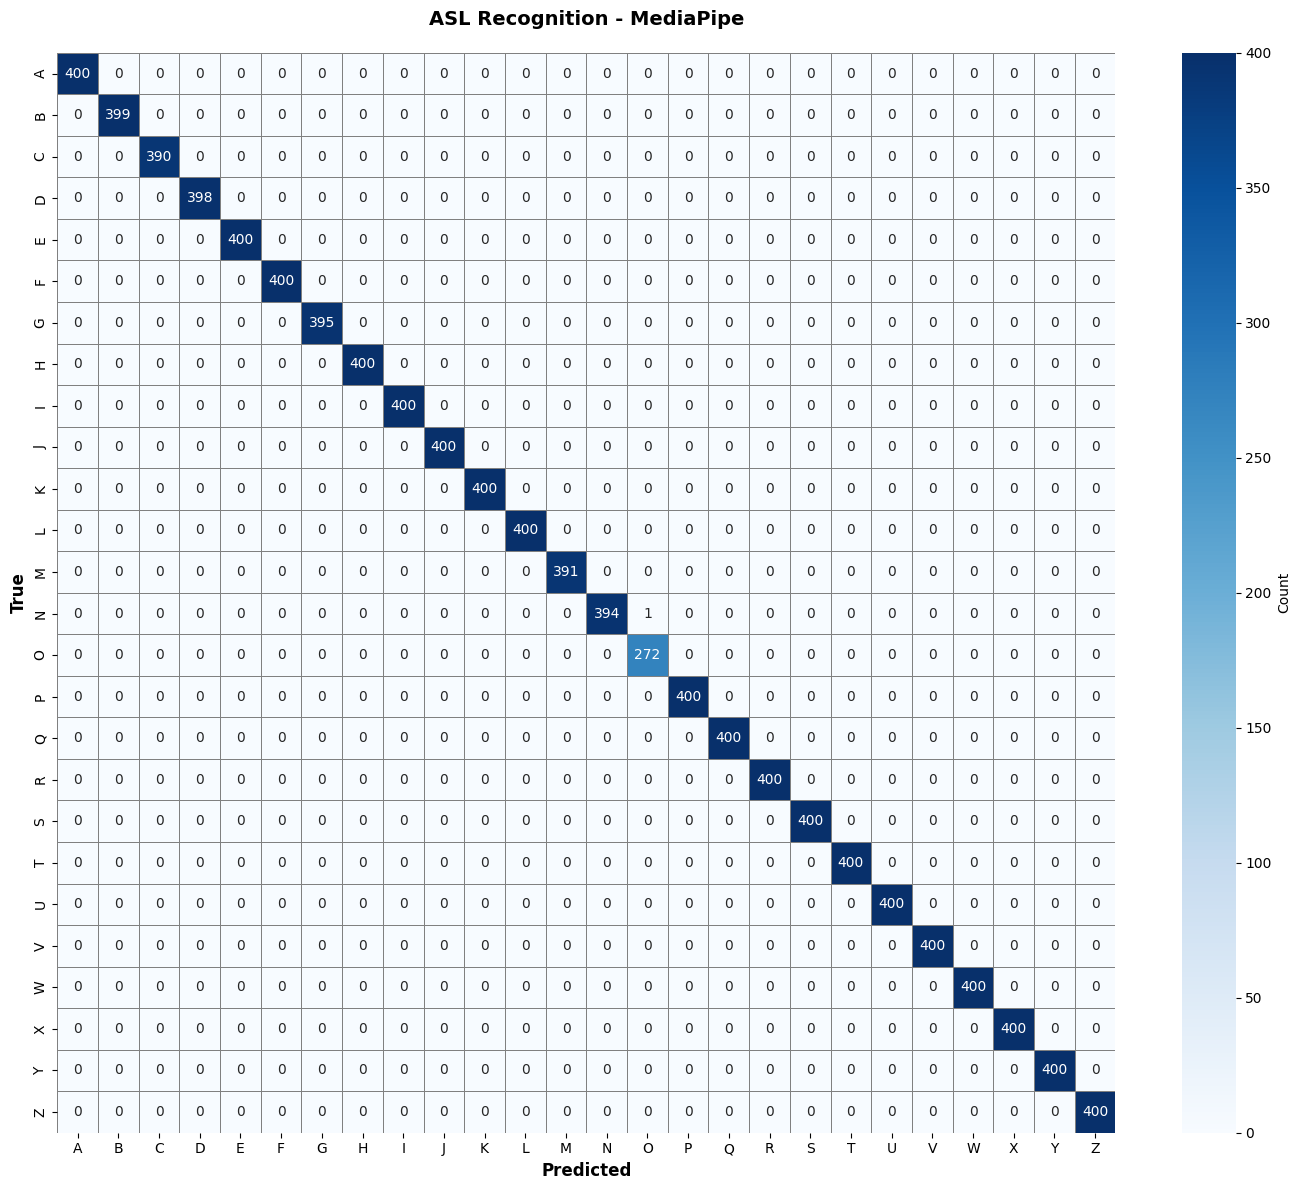

In [18]:
plot_confusion_matrix(y_test, y_test_pred, CLASSES, "ASL Recognition - MediaPipe")

## 8. Save Models

In [19]:
print("\n" + "="*60)
print("SAVING MODELS")
print("="*60)

ensure_models_dir()

joblib.dump(svm, SVM_MODEL_PATH)
print(f"  ✅ SVM: {SVM_MODEL_PATH}")

joblib.dump(scaler, SCALER_MODEL_PATH)
print(f"  ✅ Scaler: {SCALER_MODEL_PATH}")

print("\n🎉 Training completed successfully!")


SAVING MODELS
  ✅ SVM: d:\SEM 5\CompVis\Another Final Project - ASL\ComputerVision\model\models\svm_model.pkl
  ✅ Scaler: d:\SEM 5\CompVis\Another Final Project - ASL\ComputerVision\model\models\scaler.pkl

🎉 Training completed successfully!
